# `fitgrid` EEG demo

In [1]:
%matplotlib inline
import pandas as pd

import importlib
import sys
sys.path.insert(0, '..')
import fitgrid as fg

fg.__file__

'../fitgrid/__init__.py'

## 1. Read or construct a pandas.DataFrame of timestamped epochs

* Stack fixed-length epochs of digital samples in rows with the response and predictor variables in columns

* Uniquely index all the rows in each epoch with the same index. The index be gappy but duplicate indices are not allowed.

* Uniquely timestamp the rows within each epoch with an integer. The time stamps *are* duplicated a: each epoch has exactly the same time stamps.

* The "time stamps" are arbitrary indices, they are well suited to represent an ordered discrete time series sampled at a fixed rate but can also represent categories or groups of categories.

In [2]:
p3_df = pd.read_hdf(
    '../tests/data/sub000p3.epochs.h5',
    'p3'
)

n_epochs = len(p3_df['epoch_id'].unique())
n_timepoints = len(p3_df['time_ms'].unique())
print(f"Number of epochs: {n_epochs}")
print(f"Number of discrete timepoints per epoch: {n_timepoints}")
print(f"Total number of rows: number of epochs * timepoints per epoch = {n_epochs * n_timepoints}")
display(p3_df)

Number of epochs: 792
Number of discrete timepoints per epoch: 275
Total number of rows: number of epochs * timepoints per epoch = 217800


,epoch_id,time_ms,event_code,eeg_artifact,participant,MiPf,MiCe,MiPa,MiOc,stim,accuracy,acc_type,exp
0,0,-100,0,False,demonstration,-48.0,23.015625,46.031250,11.656250,target,correct,hit,p3
1,0,-96,0,False,demonstration,-52.5,19.984375,41.968750,6.800781,target,correct,hit,p3
2,0,-92,0,False,demonstration,-51.5,22.765625,43.187500,7.773438,target,correct,hit,p3
3,0,-88,0,False,demonstration,-54.0,21.750000,38.875000,5.101562,target,correct,hit,p3
4,0,-84,0,False,demonstration,-55.0,19.984375,34.812500,5.343750,target,correct,hit,p3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217795,791,980,0,False,demonstration,4.0,15.171875,15.984375,1.700195,all,all,all,p3
217796,791,984,0,False,demonstration,-2.5,13.406250,13.835938,0.728516,all,all,all,p3
217797,791,988,0,False,demonstration,7.0,25.046875,25.765625,14.335938,all,all,all,p3
217798,791,992,0,False,demonstration,1.5,22.765625,24.328125,12.390625,all,all,all,p3


## 2. choose the data to model and load  into fitgrid

In [3]:
p3_df.set_index(['epoch_id', 'time_ms'], inplace=True)

fg_epx_p3 = fg.epochs_from_dataframe(
    p3_df.query("stim in ['target', 'standard'] and eeg_artifact == False"),
    epoch_id='epoch_id',
    time='time_ms',
    channels=['MiPf', 'MiCe', 'MiPa', 'MiOc']  # defaults
)

## 3. Sweep a model across the timepoints and channels

For each response variable sweep the model across the data grouped by timepoint, $t$ 

$EEG(t) = \beta_{0}(t) + \beta_{1}(t) \cdots \beta_{J}(t) + \epsilon(t)$

In fitgrid, the model design matrix is specified with the formula language of `patsy` and `R` (lm, lme4).

In the next examples the `param` is what `statsmodels` calls the estimated coefficients $\hat{\beta}_{j}$ 

### Example: EEG ~ 1 + stim

Treatment coded: `[T.target]`  (thank you patsy)

* `Intercept` is the control or reference condition, here the frequent, so-called, *standard* stimulus.

* the `stim[T.Target]` coefficent (weight) is the effect of the "treatment", i.e., the **difference** between the frequent standard control tones and the infrequent so-called *target* stimulus.


In [4]:
%%time

lm_grid_treatment = fg.lm(
    fg_epx_p3, 
    RHS="1 + stim",
    LHS=['MiPf', 'MiCe', 'MiPa', 'MiOc'],  # fit the model at each time x channel
)

100%|██████████| 275/275 [00:10<00:00, 27.33it/s]

CPU times: user 9.86 s, sys: 257 ms, total: 10.1 s
Wall time: 40.1 s


In [5]:
lm_grid_treatment[:,'MiPa'].params.unstack()

MiPa               
        Intercept stim[T.target]
time_ms                         
-100    -1.156548      -0.242393
-96     -1.085836      -0.072052
-92     -1.054654      -0.163672
-88     -1.214169       0.455718
-84     -1.247940       1.437252
...           ...            ...
 980    -2.063161       5.377835
 984    -1.634515       4.313194
 988    -1.765098       3.920013
 992    -1.659838       3.448725
 996    -1.813002       3.296125

[275 rows x 2 columns]

## Example: EEG ~ 0 + stim

Dummy coding supresses the intercept in the model. 

Note that the treatment-coded `Intercept` with *standard* as the control/reference level and dummy coded `stim[standard]` are identical.

The `stim[T.target]` and `stim[target]` coefficients are different, the latter gives the average of the *target* epochs without whereas the former gives the average difference between the *target* and the *standard* epochs.

In [6]:
lm_grid_dummy = fg.lm(
    fg_epx_p3, 
    RHS="0 + stim",
    LHS=['MiPf', 'MiCe', 'MiPa', 'MiOc']
)

# params are the 
lm_grid_dummy[:,'MiPa'].params.unstack()

100%|██████████| 275/275 [00:09<00:00, 29.79it/s]


MiPa             
        stim[standard] stim[target]
time_ms                            
-100         -1.156548    -1.398941
-96          -1.085836    -1.157889
-92          -1.054654    -1.218326
-88          -1.214169    -0.758451
-84          -1.247940     0.189312
...                ...          ...
 980         -2.063161     3.314674
 984         -1.634515     2.678680
 988         -1.765098     2.154915
 992         -1.659838     1.788887
 996         -1.813002     1.483123

[275 rows x 2 columns]

### Plot the time course of the estimated parameters: $\hat{\beta}_{j}$

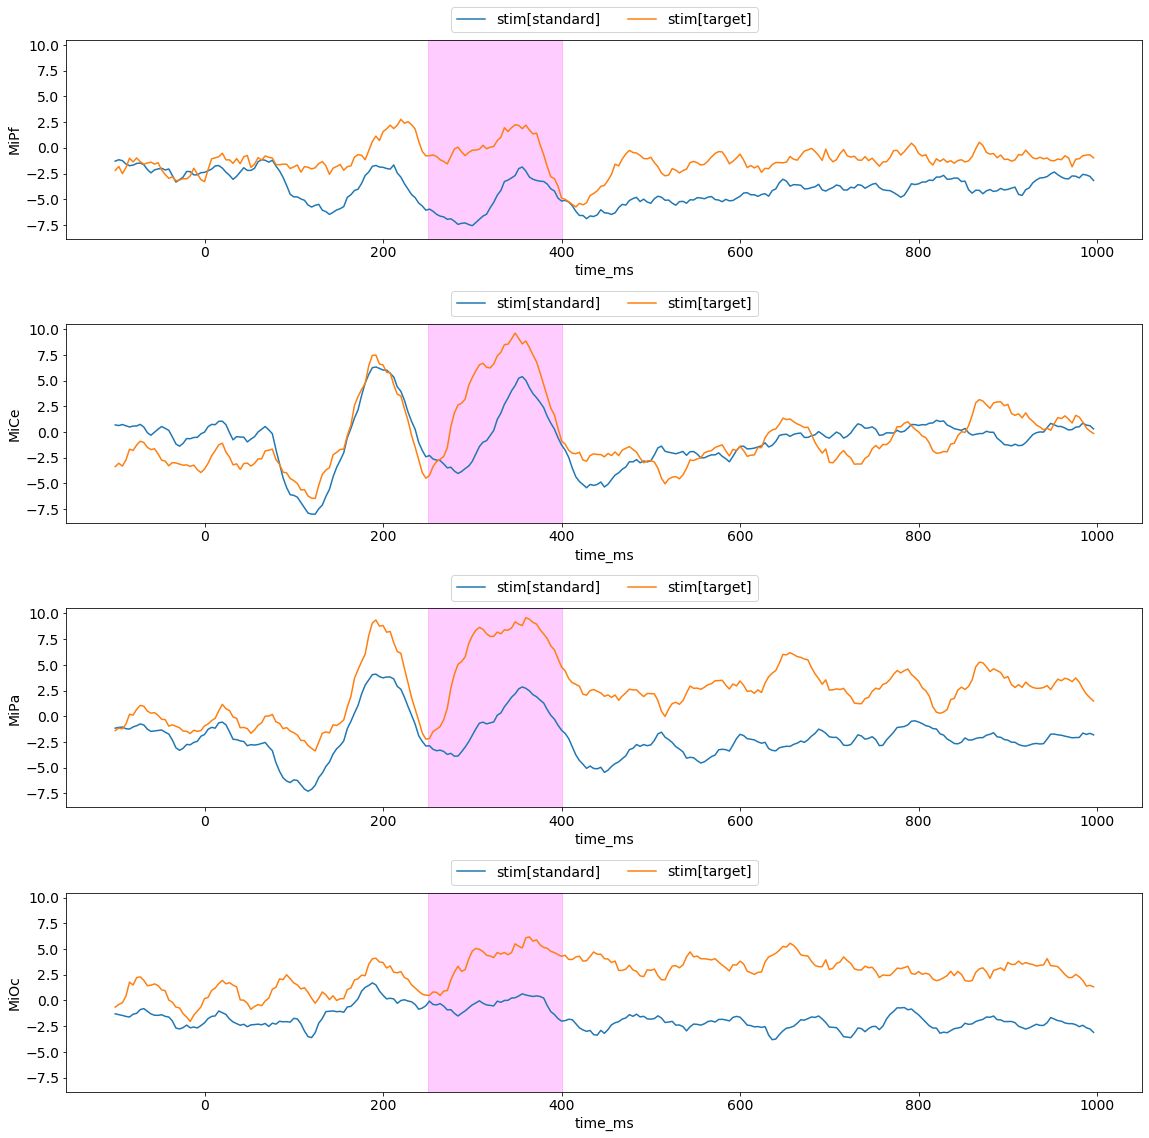

In [7]:
f, axs = lm_grid_dummy.plot_betas()
for ax in axs:
    ax.axvspan(250, 400, color='magenta', alpha=.2)

### 2.2 Plot the time course of adjusted $R^2$

Note that the choice of different coding scheme for the categorical variables affects the numerical value of the estimated model parameters, $\hat{\beta}_{j}$ but not the overall model fit, i.e. residual error.

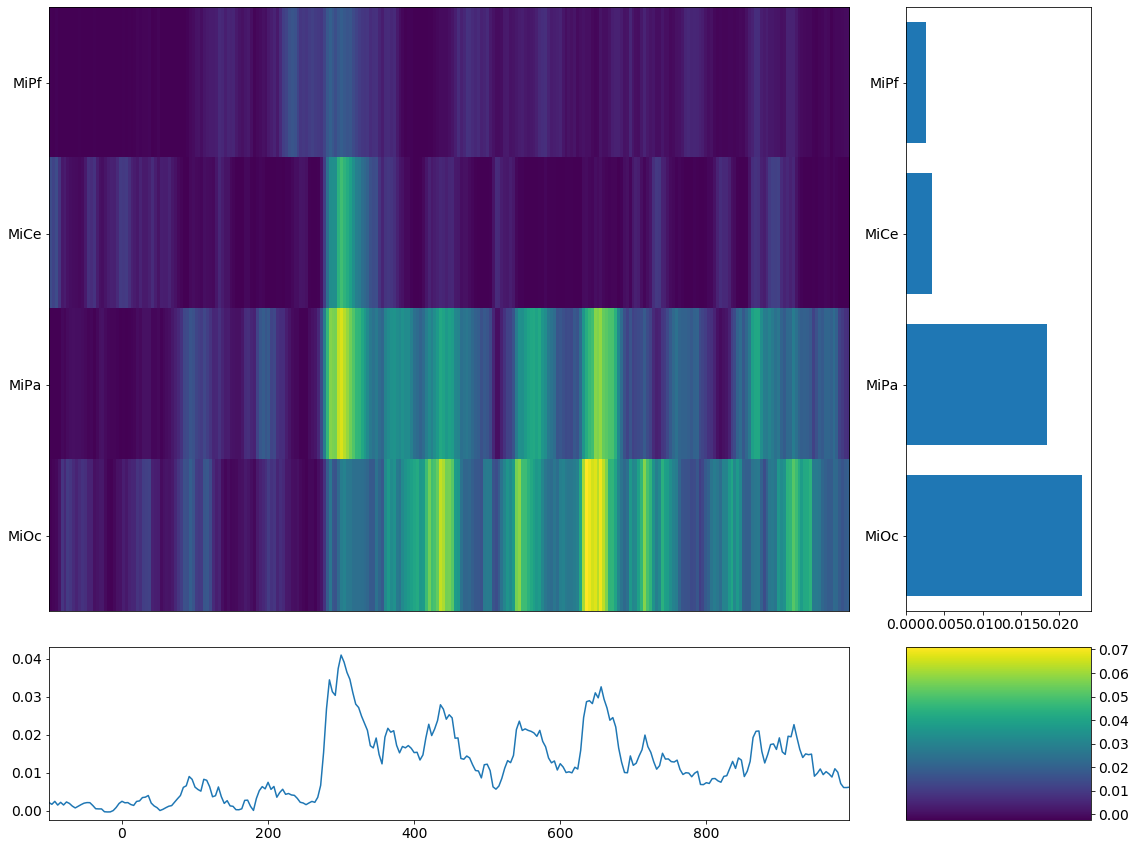

In [96]:
lm_grid_treatment.plot_adj_rsquared();

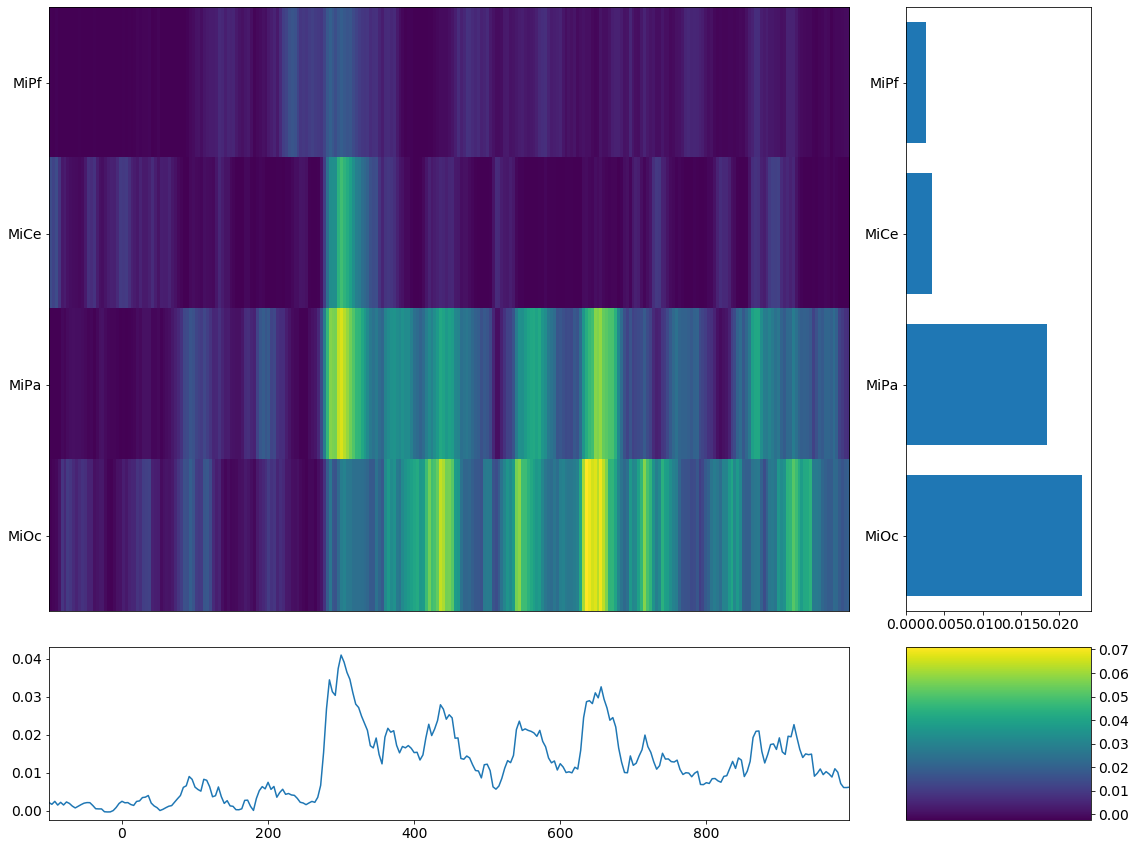

In [97]:
lm_grid_dummy.plot_adj_rsquared();

### 2.3 Access diagnostics

In [100]:
pvalues = lm_grid_treatment.pvalues.unstack()
pvalues

MiPf                     MiCe                     MiPa  \
        Intercept stim[T.target] Intercept stim[T.target] Intercept   
time_ms                                                               
-100     0.383054       0.714576  0.434465       0.006353  0.261256   
-96      0.432208       0.789486  0.465173       0.011179  0.277021   
-92      0.393465       0.607920  0.409165       0.006478  0.301481   
-88      0.293295       0.888429  0.503969       0.027962  0.237043   
-84      0.238327       0.765819  0.584428       0.147969  0.214023   
...           ...            ...       ...            ...       ...   
 980     0.025485       0.392939  0.585232       0.548261  0.043838   
 984     0.052349       0.415291  0.352836       0.949228  0.106011   
 988     0.045428       0.380703  0.467414       0.856891  0.076351   
 992     0.034886       0.339335  0.494546       0.726842  0.087438   
 996     0.016708       0.319437  0.733416       0.764646  0.062025   

                            MiOc                 
        stim[T.target] Intercept stim[T.target]  
time_ms                                          
-100          0.887918  0.137483       0.655056  
-96           0.965561  0.115011       0.495733  
-92           0.923540  0.111489       0.420755  
-88           0.790496  0.089230       0.193305  
-84           0.391767  0.077683       0.026184  
...                ...       ...            ...  
 980          0.001735  0.003716       0.000986  
 984          0.010907  0.004579       0.002194  
 988          0.018719  0.001551       0.003853  
 992          0.033825  0.000978       0.002501  
 996          0.042495  0.000282       0.001885  

[275 rows x 8 columns]

In [9]:
tvalues = lm_grid.tvalues

In [10]:
rsquared_adj = lm_grid.rsquared_adj

# Epochs from a dataframe

In [118]:
import pandas as pd

idx_cols = ['epoch_id', 'time_ms']
lhs_cols = ['MiPf', 'MiCe', 'MiPa', 'MiOc']
rhs_cols = ['congruity', 'idx'] 

wr_epochs_df = (
    pd.read_hdf('../tests/data/sub000wr.epochs.h5', key='wr')
     .set_index(['epoch_id', 'time_ms'], append=True)
)
wr_epochs_df

,,,event_code,eeg_artifact,participant,MiPf,MiCe,MiPa,MiOc,congruity,idx,exp
,epoch_id,time_ms,,,,,,,,,,
0,0,-100,0,False,demonstration,-9.0,17.953125,8.585938,8.500000,incongruent,124,wr
1,0,-96,0,False,demonstration,-13.0,11.382812,9.539062,13.359375,incongruent,124,wr
2,0,-92,0,False,demonstration,-19.5,8.093750,12.164062,14.335938,incongruent,124,wr
3,0,-88,0,False,demonstration,-23.5,8.343750,14.546875,17.000000,incongruent,124,wr
4,0,-84,0,False,demonstration,-31.5,8.343750,15.265625,10.687500,incongruent,124,wr
...,...,...,...,...,...,...,...,...,...,...,...,...
79195,287,980,0,False,demonstration,-35.0,-39.218750,-29.093750,-16.515625,incongruent,100,wr
79196,287,984,0,False,demonstration,-37.0,-42.500000,-31.968750,-15.789062,incongruent,100,wr
79197,287,988,0,False,demonstration,-28.5,-36.687500,-28.625000,-10.929688,incongruent,100,wr


# Fit LMER

In [123]:
%%time

lmer_grid = fg.lmer(
    fg.epochs_from_dataframe(
        wr_epochs_df,
        time='time_ms',
        epoch_id='epoch_id',
        channels=lhs_cols
    ),
    RHS = "1 + (1 | idx)",
    LHS = lhs_cols,
    parallel=True,
    n_cores=4,
    REML=False,
)


100%|██████████| 275/275 [00:00<00:00, 487.95it/s][A
/home/turbach/.conda/envs/test_mkconda-0.0.10/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/turbach/.conda/envs/test_mkconda-0.0.10/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/turbach/.conda/envs/test_mkconda-0.0.10/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = Pa

CPU times: user 6.58 s, sys: 844 ms, total: 7.43 s
Wall time: 3min 41s


# See what's available in the LMER grid

Not everything is fully implemented

In [124]:
dir(lmer_grid)

['AIC',
 '_REML',
 '_conf_int',
 '_make_factors',
 '_permute',
 '_refit_orthogonal',
 'anova',
 'coefs',
 'factors',
 'factors_prev_',
 'family',
 'fit',
 'fits',
 'fitted',
 'fixef',
 'formula',
 'grps',
 'has_warning',
 'logLike',
 'marginal_contrasts',
 'marginal_estimates',
 'plot',
 'plot_summary',
 'post_hoc',
 'predict',
 'ranef',
 'ranef_corr',
 'ranef_var',
 'resid',
 'save',
 'sig_type',
 'simulate',
 'summary',
 'warning',
 'warnings']

In [125]:
-2 * lmer_grid.logLike.head()

,MiPf,MiCe,MiPa,MiOc
time_ms,,,,
-100,2536.414850,2471.318872,2469.826557,2285.498253
-96,2539.852654,2490.562126,2481.973029,2294.373932
-92,2542.086383,2486.489679,2481.269585,2285.843590
-88,2542.628112,2479.276322,2475.453334,2286.998378
-84,2531.346854,2460.998662,2465.016718,2266.686709


In [126]:
lmer_grid.AIC.head()

,MiPf,MiCe,MiPa,MiOc
time_ms,,,,
-100,2536.414850,2471.318872,2469.826557,2285.498253
-96,2539.852654,2490.562126,2481.973029,2294.373932
-92,2542.086383,2486.489679,2481.269585,2285.843590
-88,2542.628112,2479.276322,2475.453334,2286.998378
-84,2531.346854,2460.998662,2465.016718,2266.686709


In [129]:
lmer_grid.coefs

MiPf      MiCe      MiPa      MiOc
time_ms                                                                
-100    (Intercept) Estimate     -14.9653  -6.06596  -6.07264  -3.06109
                    2.5_ci       -17.3188  -8.11644  -8.11779   -4.5445
                    97.5_ci      -12.6118  -4.01548  -4.02748  -1.57768
                    SE            1.20078   1.04618   1.04347  0.756858
                    DF                143       287       287       287
...                                   ...       ...       ...       ...
 996    (Intercept) SE            1.56278  0.947417   1.00682  0.716277
                    DF                143       143       143       143
                    T-stat       -5.56235  -0.35348  0.544761  -1.56984
                    P-val     1.26932e-07  0.724249  0.586766  0.118662
                    Sig               ***                              

[2200 rows x 4 columns]

In [130]:
lmer_grid.coefs

MiPf      MiCe      MiPa      MiOc
time_ms                                                                
-100    (Intercept) Estimate     -14.9653  -6.06596  -6.07264  -3.06109
                    2.5_ci       -17.3188  -8.11644  -8.11779   -4.5445
                    97.5_ci      -12.6118  -4.01548  -4.02748  -1.57768
                    SE            1.20078   1.04618   1.04347  0.756858
                    DF                143       287       287       287
...                                   ...       ...       ...       ...
 996    (Intercept) SE            1.56278  0.947417   1.00682  0.716277
                    DF                143       143       143       143
                    T-stat       -5.56235  -0.35348  0.544761  -1.56984
                    P-val     1.26932e-07  0.724249  0.586766  0.118662
                    Sig               ***                              

[2200 rows x 4 columns]

In [8]:
import fitgrid.utils as fgutil

In [12]:
%%time

lm_comp_p3 = fgutil.summary.summarize(
    fg_epx_p3,
    modeler='lm',
    RHS=[
        "1",
        "1 + stim",
    ],
    LHS=["MiPf", "MiCe", "MiPa", "MiOc"],
    parallel=False,
)
 
    

100%|██████████| 275/275 [00:09<00:00, 28.23it/s]


CPU times: user 19.6 s, sys: 718 ms, total: 20.3 s
Wall time: 20.1 s


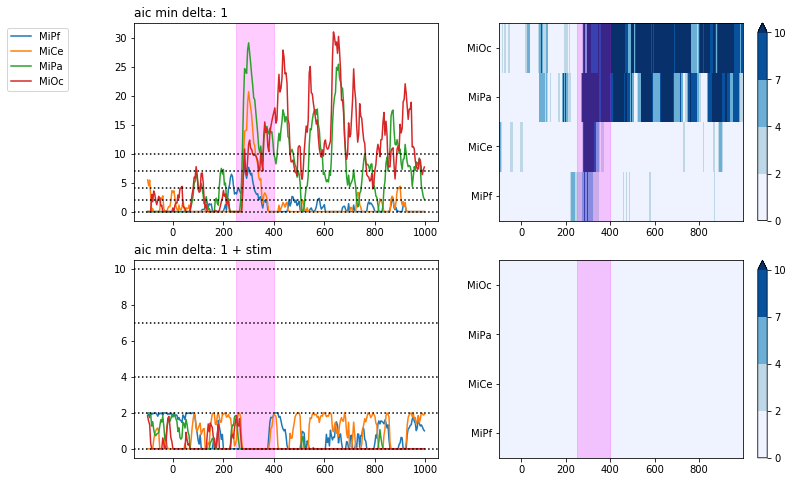

In [27]:
f, axs = fgutil.summary.plot_AICmin_deltas(lm_comp_p3)

# highlight P300
for axi in axs:
    for axj in axi:
        axj.axvspan(250, 400, color='magenta', alpha=.2)

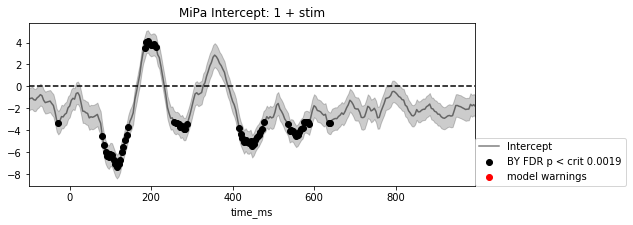

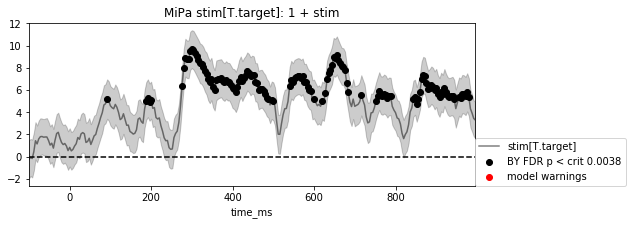

In [42]:
import numpy as np
fgutil.summary.plot_betas(lm_comp_p3.query('model=="1 + stim"'), LHS=['MiPa'], fdr='BY');


In [30]:
lm_comp_p3

MiPf          MiCe  \
time_ms model    beta           key                                        
-100    1        Intercept      2.5_ci           -3.946743     -2.163097   
                                97.5_ci           0.712798      0.644758   
                                AIC            4036.455459   3594.790712   
                                DF              435.000000    435.000000   
                                Estimate         -1.616972     -0.759170   
...                                                    ...           ...   
 996    1 + stim stim[T.target] SSresid      212968.539400  96278.816552   
                                T-stat            0.996759     -0.299574   
                                has_warning       0.000000      0.000000   
                                logLike       -1968.351333  -1795.281976   
                                sigma2          490.710920    221.840591   

                                                      MiPa          MiOc  
time_ms model    beta           key                                       
-100    1        Intercept      2.5_ci           -2.860822     -2.449542  
                                97.5_ci           0.374270      0.309491  
                                AIC            3718.297688   3579.495537  
                                DF              435.000000    435.000000  
                                Estimate         -1.243276     -1.070025  
...                                                    ...           ...  
 996    1 + stim stim[T.target] SSresid      114109.045126  87142.219118  
                                T-stat            2.034635      3.126888  
                                has_warning       0.000000      0.000000  
                                logLike       -1832.321529  -1773.545886  
                                sigma2          262.924067    200.788523  

[9900 rows x 4 columns]